In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# 3.7.2. High-Dimensional Linear Regression

In [3]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

# Defining $l_2$ Norm Penalty

In [4]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

# 3.7.3.2. Defining the Model

In [11]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) + self.lambd * l2_penalty(self.w))

In [ ]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

# 3.7.3.3. Training without Regularization

L2 norm of w: 0.011608422733843327


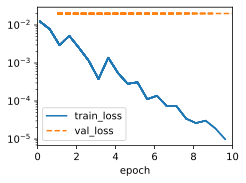

In [13]:
train_scratch(0)

# 3.7.3.4. Using Weight Decay

L2 norm of w: 0.0011985055170953274


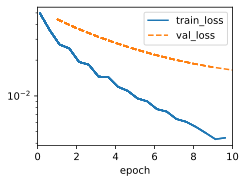

In [14]:
train_scratch(3)

# 3.7.4. Concise Implementation

In [15]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}
        ], lr=self.lr)

L2 norm of w: 0.015056470409035683


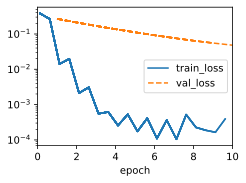

In [16]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))


# 3.7.6. Exercises

## 2.

lambda=10, validation loss=0.0225
Best lambda: 10


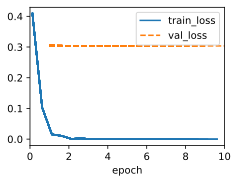

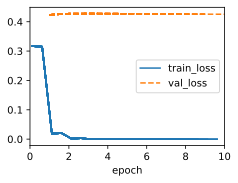

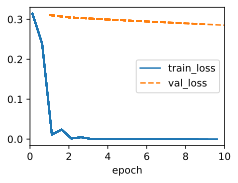

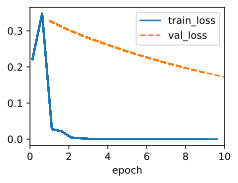

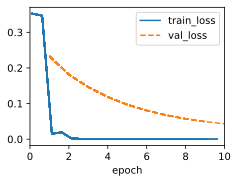

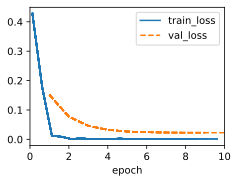

In [17]:
import numpy as np

lambdas = [0, 0.01, 0.1, 1, 3, 10]
val_losses = []

for lambd in lambdas:
    model = WeightDecay(wd=lambd, lr=0.01)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    # Evaluate on validation set
    model.eval()
    val_loss = 0
    n = 0
    for X, y in data.val_dataloader():
        y_hat = model(X)
        val_loss += nn.MSELoss()(y_hat, y).item() * y.shape[0]
        n += y.shape[0]
    val_loss /= n
    val_losses.append(val_loss)
    print(f"lambda={lambd}, validation loss={val_loss:.4f}")

best_lambda = lambdas[np.argmin(val_losses)]
print(f"Best lambda: {best_lambda}")